In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp search

In [3]:
#export
import sys
sys.path.insert(0,'..')
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from food.paths import *
from stego.segment import get_food_segment
from segmentor.segment import *

from mytools.visual import *
from food.depth import *

dev
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/home/dima/FoodSeg103-Benchmark-v1/checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [4]:
#export
bad_cats  = ['Vegetables on a sandwich','Candy containing chocolate','Baby juice']
bad_descs = ['Banana, fried']


foods = pd.read_sql("""select f.*
                        from food.foods_prompted f""",engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

foods = foods[~foods['category'].isin(bad_cats)]
foods = foods[~foods['description'].isin(bad_descs)]

food_clips = series2tensor(foods['clip'])

/home/dima/mytools/mytools/tools.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [5]:
# calories = energy_mask/100*0.001*20
# weight = np.where(energy_mask!=0,1,0)
# (weight*0.001*30).sum()
# calories.sum()

In [6]:
#export
def search(url):
    img = get_image_from_url(url)
    img = crop_image_to_square(img)
    photo_id = url.split('/')[-1]
    i = np.asarray(img, dtype="uint8")
    i = np.flip(i,2)
    segmentor_mask = inference_segmentor(segment_model, i)[0]

    classes = np.unique(segmentor_mask)[1:]
    classes_ =[]
    urls = []
    for c in classes:
        area = segmentor_mask[segmentor_mask==c].shape[0]
        if area> 20*20:
            class_mask = np.where(segmentor_mask==c,1,0)
            class_mask = expand_boundaries(class_mask,times=5,factor=5)
            img_arr = apply_mask(img,class_mask.T).astype(np.uint8)
            img_arr = crop_zeros(img_arr)
            img_arr[img_arr==[0,0,0]]=255 #replace black with while
            fname = f'{photo_id}_{c}.jpg'

            Image.fromarray(img_arr).save(fragment_reference_images_path/fname)
            urls.append(f'https://dima.grankin.eu/fragment_reference_images/{fname}')
            classes_.append(c+1)

    classes = classes_
    stego_img,stego_mask = get_food_segment(img)
    stego_img.save(fragment_reference_images_path/f'{photo_id}_stego.jpg')
    urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_stego.jpg')

    clip_df = pd.DataFrame()
    for u in urls:
        clip_df = clip_df.append(search_clip(u,foods,food_clips,head = 1)[1])
    clip_df=clip_df.reset_index(drop=True)
    clip_df['classes'] = classes+[1]
    clip_df=clip_df[clip_df['score']>0.22]

    mask = stego_mask+segmentor_mask

    dicts =[]
    masks =[]

    attributes = ['energy','protein','carb','fat']
    #create masks of attributes
    for col in attributes:
        dicts.append(clip_df[['classes',col]].set_index("classes")[col].to_dict())
        masks.append(torch.clone(mask))

    areas = {}
    for c in np.unique(mask):
        areas[c]= mask[mask==c].shape[0]

        #clean values where classes are filtered out
        if c not in dicts[0].keys():
            for m in masks:
                m[m==c]=0

    #areas          
    clip_df = clip_df.merge(pd.DataFrame(areas,index = ['area']).T,left_on = 'classes',right_index = True)
    clip_df['area'] = clip_df['area']/clip_df['area'].sum()
    clip_df = clip_df.sort_values('area',ascending = False)

    #assign values to the masks
    for d,m in zip(dicts,masks):
        for k,v in d.items(): m[m == k] = v

    stats = pd.DataFrame([float(m[m!=0].mean()) for m in masks]+[masks[0][masks[0]!=0].shape[0]],
                     index = attributes+['size'])

    img = np.array(img)

    mask = mask.numpy().astype(np.uint8)
    true_points = np.argwhere(np.array(img)+np.stack([mask]*3).T)
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)

    img = img[top_left[0]:bottom_right[0]+1,
              top_left[1]:bottom_right[1]+1]

    img = Image.fromarray(img.astype(np.uint8))

    masks_ = []
    for mask in masks:
        masks_.append(mask[top_left[0]:bottom_right[0]+1,
                    top_left[1]:bottom_right[1]+1])
    masks = masks_
    
    return img,clip_df,masks,urls,stats

In [17]:
url = 'https://image.shutterstock.com/z/stock-photo-baked-ribs-with-french-fries-and-cabbage-salad-1020686221.jpg'

In [18]:
img,clip_df,masks,urls,stats = search(url)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f

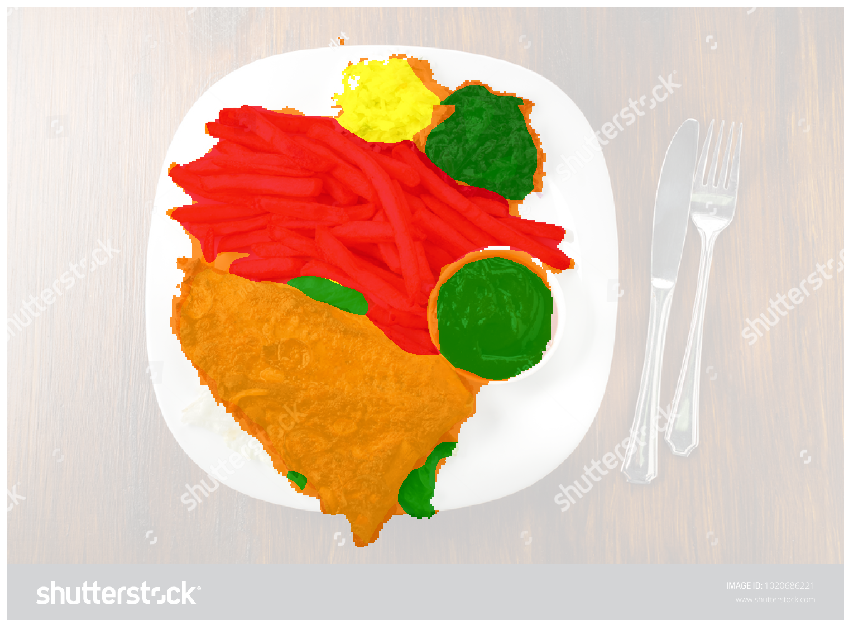

In [19]:
i = visualize_array(masks[0].numpy(),img)

In [20]:
stats.T.astype(int).drop(columns = ['size'])

,energy,protein,carb,fat
0,214,12,25,10


In [21]:
clip_df

,id,description,category,energy,protein,carb,fat,text,clip,score,classes,area
0,1102961,"Potato, french fries, fast food",French fries and other fried white potatoes,312.0,3.43,41.44,14.73,the food is french fries and other fried white...,"[0.032709457, 0.019629562, 0.016649079, 0.0157...",0.273017,4,0.370079
2,1098239,"Pork chop, broiled or baked, NS as to fat eaten",Pork,211.0,27.69,0.00,10.50,the food is pork . it has a little bit of ns...,"[0.006321707, -0.0013432651, 0.00930761, -0.01...",0.282675,48,0.316537
3,1100178,"Gravy, poultry, fat free","Dips, gravies, other sauces",48.0,0.71,5.29,2.62,"the food is dips, gravies, other sauces . it h...","[-0.004480094, 0.0058389646, -0.014452294, 0.0...",0.267632,53,0.087649
8,1098520,"Chicken thigh, baked or broiled, skin eaten, f...","Chicken, whole pieces",226.0,22.51,0.12,15.08,"the food is chicken, whole pieces . it has a l...","[-0.006833324, 0.025729777, -0.010450681, 0.00...",0.244984,1,0.079332
6,1103477,"Cabbage, red, cooked",Cabbage,55.0,1.45,7.44,2.80,the food is cabbage . it has a little bit of ...,"[0.035288464, -0.0433172, -0.014358983, 0.0140...",0.314032,92,0.056088
4,1102392,"Rice, white, with carrots, no added fat",Rice mixed dishes,106.0,2.20,23.14,0.25,the food is rice mixed dishes . it has a littl...,"[0.00841078, -0.00020586317, -0.01218943, 0.02...",0.285254,67,0.030125
5,1103474,"Cabbage, green, cooked, fat added, NS as to fa...",Cabbage,49.0,1.30,5.85,2.74,the food is cabbage . it has a little bit of ...,"[0.03719616, 0.0029577848, 0.0022090955, 0.017...",0.256186,81,0.028989
1,1101649,"Rice, white and wild, cooked, fat added",Rice,112.0,2.17,20.62,2.14,the food is rice . it has a little bit of fa...,"[0.007363078, -0.016586864, -0.026016425, 0.01...",0.270873,9,0.018920
7,1103474,"Cabbage, green, cooked, fat added, NS as to fa...",Cabbage,49.0,1.30,5.85,2.74,the food is cabbage . it has a little bit of ...,"[0.03719616, 0.0029577848, 0.0022090955, 0.017...",0.235863,104,0.012281


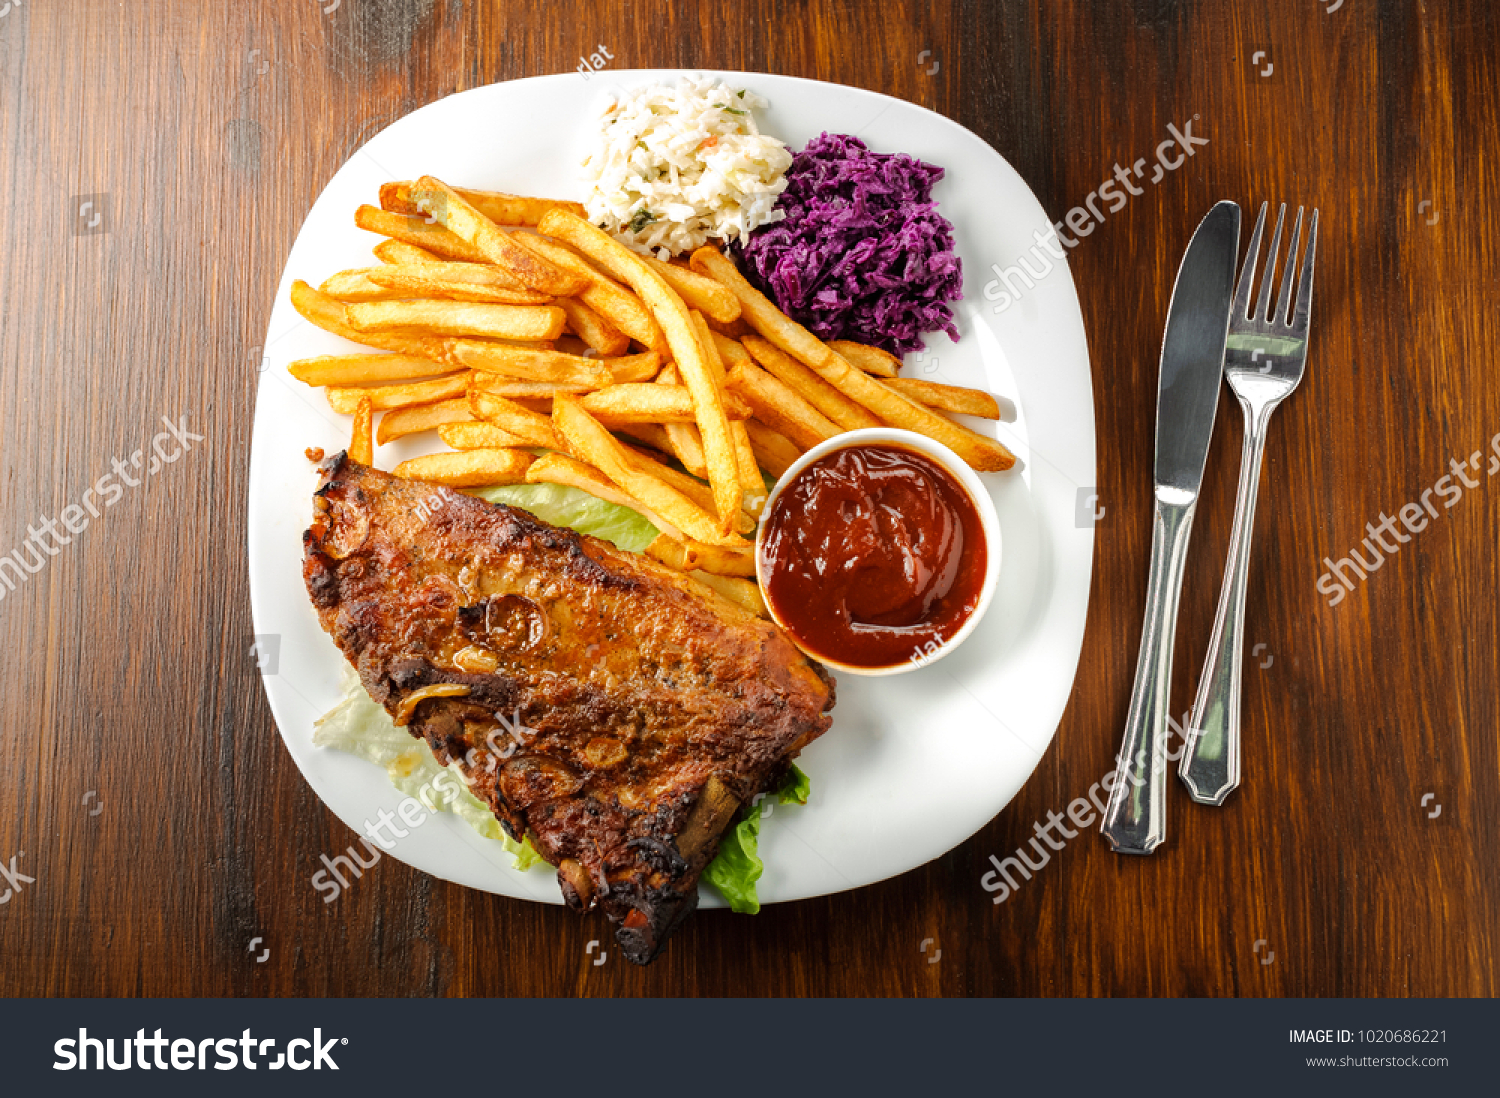

In [22]:
img

In [139]:
dishes = pd.DataFrame(dishes,columns = ['amount','energy','protein'])

In [22]:
mean_energy  = (dishes['amount']*dishes['energy']).sum()/dishes['amount'].sum()
mean_protein = (dishes['amount']*dishes['protein']).sum()/dishes['amount'].sum()

TypeError: list indices must be integers or slices, not str

In [23]:
!conda activate f4; nbdev_build_lib

Converted 00_paths.ipynb.
Converted 00_psql.ipynb.
Converted 01_search.ipynb.
Converted bot.ipynb.
Converted depth.ipynb.
Converted inference.ipynb.
Converted search_dev.ipynb.
Converted search_segmented_stable.ipynb.
Converted stats.ipynb.
Converted usda.ipynb.
Converted usda_parsing.ipynb.
